
### présenté par :
# Abel KPOHINTO

Apprenez plus sur le modèle GARCH : http://home.iitj.ac.in/~parmod/document/GARCH%20Forecasting%20Model.pdf

Installation de la library arch pour avoir accès au modèle GARCH

In [ ]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 8.9 MB/s eta 0:00:00


In [ ]:
import warnings

import pandas as pd
import numpy as np
import requests
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings("ignore")

## Récupération des données depuis Alpha Vantage

On récupère toutes les données disponible sur AlphaVantage depuis 2014 jusqu'à aujourd'hui

In [ ]:
from_symbol="USD"
to_symbol="EUR"
output_size="full"
api_key="WGP5Z8XOP1OGD3H0" #put your api_key or write demon if you don't have one

In [ ]:
url = (
  "https://www.alphavantage.co/query?"
  "function=FX_DAILY&"
  f"from_symbol={from_symbol}&"
  f"to_symbol={to_symbol}&"
  f"outputsize={output_size}&"
  f"datatype=json&"
  f"apikey={api_key}"
)

response = requests.get(url=url)
response_data = response.json()


In [ ]:
print(response_data.keys())

dict_keys(['Meta Data', 'Time Series FX (Daily)'])


In [ ]:
meta_data = response_data['Meta Data']
meta_data

{'1. Information': 'Forex Daily Prices (open, high, low, close)',
 '2. From Symbol': 'USD',
 '3. To Symbol': 'EUR',
 '4. Output Size': 'Full size',
 '5. Last Refreshed': '2024-06-06 18:30:00',
 '6. Time Zone': 'UTC'}

Avec les métadonnées on peut voir qu'on a 5 colomnes:
- Open pour le prix quand le marché ouvre
- high pour le prix le plus haut de la journée
- low pour le prix le bas de la journée
- close pour le prix lors de la fermeture du marché

In [ ]:
stock_data = response_data['Time Series FX (Daily)']
stock_data.keys()

In [ ]:
df = pd.DataFrame.from_dict(stock_data, orient="index", dtype="float")
print(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 2489 entries, 2024-06-06 to 2014-11-24
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   1. open   2489 non-null   float64
 1   2. high   2489 non-null   float64
 2   3. low    2489 non-null   float64
 3   4. close  2489 non-null   float64
dtypes: float64(4)
memory usage: 97.2+ KB
None


,1. open,2. high,3. low,4. close
2024-06-06,0.9194,0.9203,0.9173,0.9182
2024-06-05,0.9190,0.9210,0.9181,0.9196
2024-06-04,0.9165,0.9205,0.9159,0.9189
2024-06-03,0.9214,0.9233,0.9166,0.9170
2024-05-31,0.9229,0.9247,0.9187,0.9213
2024-05-30,0.9255,0.9267,0.9218,0.9228
2024-05-29,0.9206,0.9257,0.9206,0.9253
2024-05-28,0.9206,0.9210,0.9181,0.9205
2024-05-27,0.9214,0.9221,0.9200,0.9208
2024-05-24,0.9244,0.9252,0.9207,0.9217


#### Nous allons transformer les index en date et changer les noms des columns.

In [ ]:
df.index = pd.to_datetime(df.index)
df.index.name = "date"
df.columns = [c.split(". ")[1] for c in df.columns]
df.head()

,open,high,low,close
date,,,,
2024-06-06,0.9194,0.9203,0.9173,0.9182
2024-06-05,0.9190,0.9210,0.9181,0.9196
2024-06-04,0.9165,0.9205,0.9159,0.9189
2024-06-03,0.9214,0.9233,0.9166,0.9170
2024-05-31,0.9229,0.9247,0.9187,0.9213


Pour cet exemple nous allons utiliser la variance entre les rendements des prix à chaque fermeture du marché.

In [ ]:
df.sort_index(ascending=True, inplace=True)
df["return"] = df["close"].pct_change() * 100

#df["return"].dropna(inplace=True)
df.head(10)

,open,high,low,close,return
date,,,,,
2014-11-24,0.8081,0.8085,0.8032,0.8036,NaN
2014-11-25,0.8037,0.8059,0.8007,0.8014,-0.273768
2014-11-26,0.8014,0.8034,0.7980,0.7993,-0.262041
2014-11-27,0.7993,0.8024,0.7983,0.8022,0.362817
2014-11-28,0.8023,0.8044,0.8004,0.8028,0.074794
2014-12-01,0.8031,0.8049,0.7994,0.8015,-0.161933
2014-12-02,0.8015,0.8077,0.8013,0.8073,0.723643
2014-12-03,0.8072,0.8127,0.8067,0.8123,0.619348
2014-12-04,0.8123,0.8130,0.8028,0.8076,-0.578604


In [ ]:
y_FX_USDEUR = df["return"].dropna()
y_FX_USDEUR.head()

date
2014-11-25   -0.273768
2014-11-26   -0.262041
2014-11-27    0.362817
2014-11-28    0.074794
2014-12-01   -0.161933
Name: return, dtype: float64

## Exploration

Au cours de chaque journée d'échanges, le cours de l'EURO/USD varie. Lorsque nous cherchons à déterminer si c'est le bon moment pour échanger de l'argent, nous examinons quatre types de chiffres : l'ouverture (open), le sommet(high), le creux(low) et la clôture(close).

Voyons comment évolue cours de l'EUR/USD

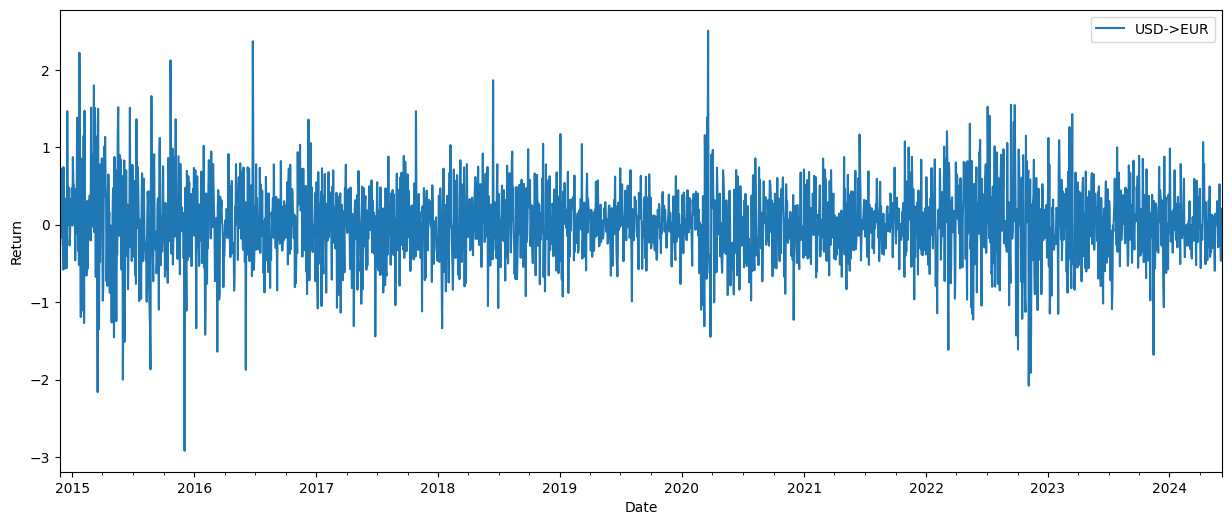

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
y_FX_USDEUR.plot(ax=ax, label="USD->EUR")

plt.xlabel("Date")
plt.ylabel("Return")

plt.legend();

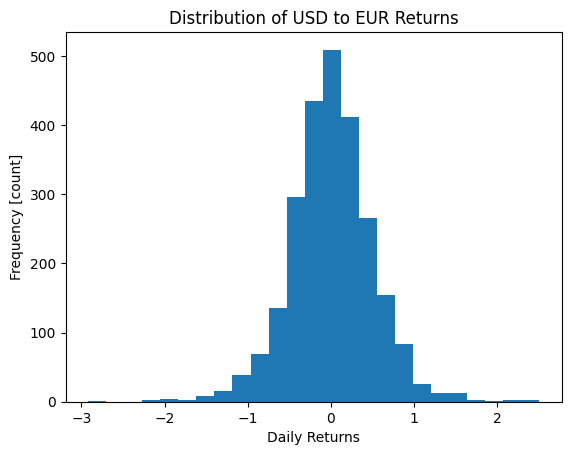

In [ ]:
plt.hist(y_FX_USDEUR, bins=25)

# Add axis labels
plt.xlabel("Daily Returns")
plt.ylabel("Frequency [count]")


# Add title
plt.title("Distribution of USD to EUR Returns");

La volatilité sur une journée

In [ ]:
usd_daily_volatility = y_FX_USDEUR.std()
print("USD Daily Volatility:", usd_daily_volatility)

USD Daily Volatility: 0.49408667314359034


La volatilité sur une année

In [ ]:
usd_annual_volatility = usd_daily_volatility * np.sqrt(252)
print("USD Annual Volatility:", usd_annual_volatility)

USD Annual Volatility: 7.843382779495176


L'indicateur Rolling Volatility calcule la volatilité des mouvements de prix d'un actif sur une période donnée. Il mesure le degré de variation de la série de prix au fil du temps, ce qui donne une idée du potentiel de fluctuation des prix sur le marché. (source: https://www.tradingview.com/script/RCRc38L9-Rolling-Volatility-Indicator/#:~:text=The%20Rolling%20Volatility%20indicator%20calculates,market's%20potential%20for%20price%20fluctuations.)

In [ ]:
usd_rolling_50d_volatility = y_FX_USDEUR.rolling(window=50).std().dropna()
usd_rolling_50d_volatility.head()

date
2015-02-02    0.626521
2015-02-03    0.649877
2015-02-04    0.661159
2015-02-05    0.692490
2015-02-06    0.716409
Name: return, dtype: float64

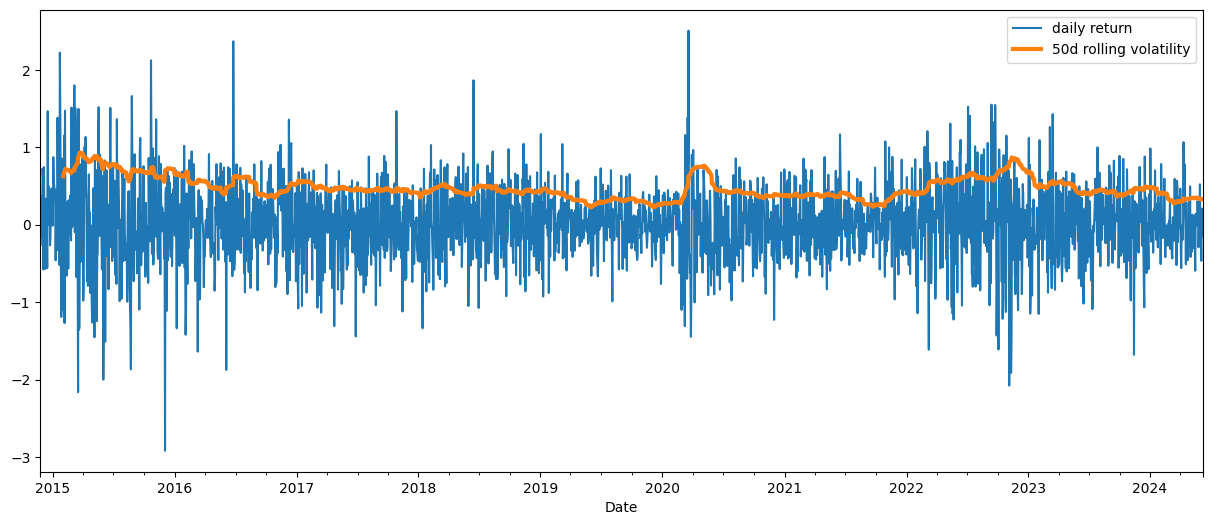

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

y_FX_USDEUR.plot(ax=ax, label="daily return")

usd_rolling_50d_volatility.plot(ax=ax, label="50d rolling volatility", linewidth=3)

# Add x-axis label
plt.xlabel("Date")

# Add legend
plt.legend();

Les modèles GARCH capturent la dynamique de la volatilité en utilisant les rendements au carré. Visualisons les courbes de l'ACF et du PACF des rendements au carré est pour diagnostiquer et comprendre le comportement de la volatilité avant d'ajuster un modèle GARCH.


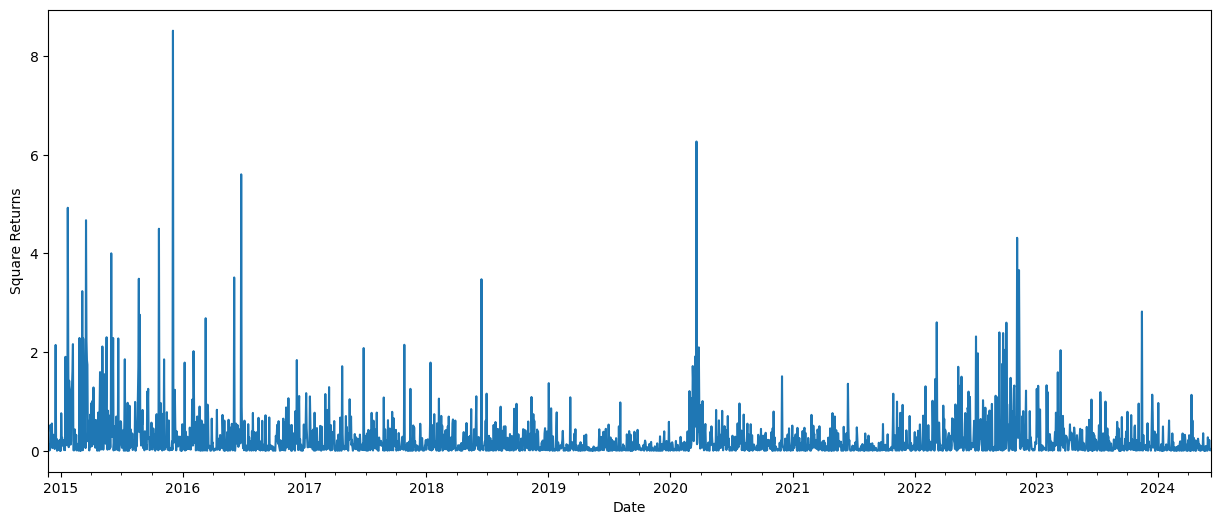

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot squared returns
(y_FX_USDEUR**2).plot(ax=ax)

# Add axis labels
plt.xlabel("Date")
plt.ylabel("Square Returns");

Text(0, 0.5, 'Correlation Coefficient')

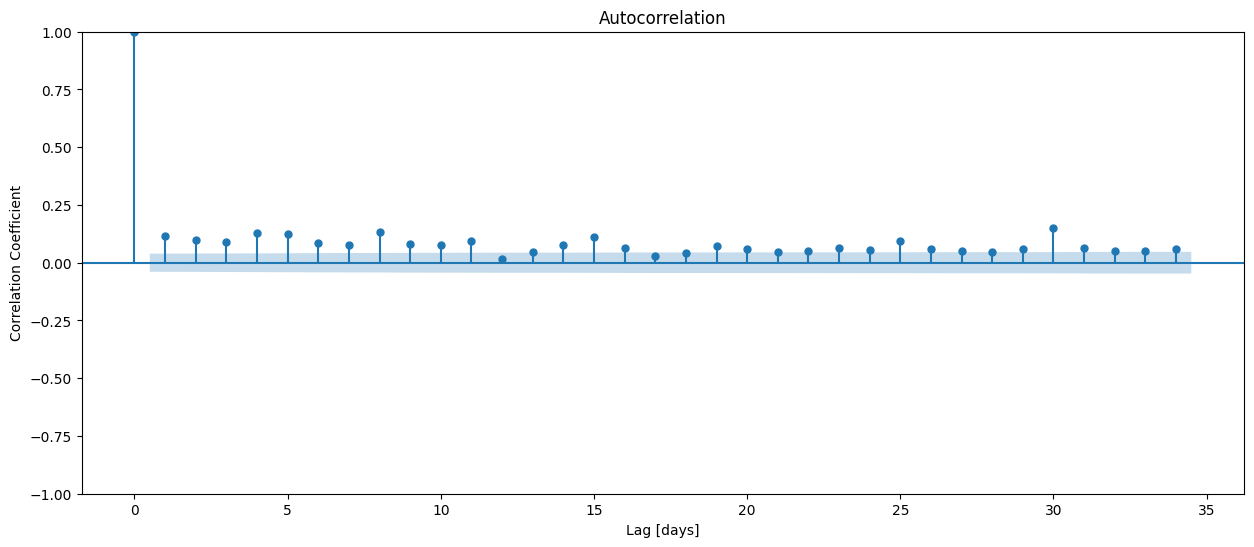

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
# Create ACF of squared returns
plot_acf(y_FX_USDEUR**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")

Text(0, 0.5, 'Correlation Coefficient')

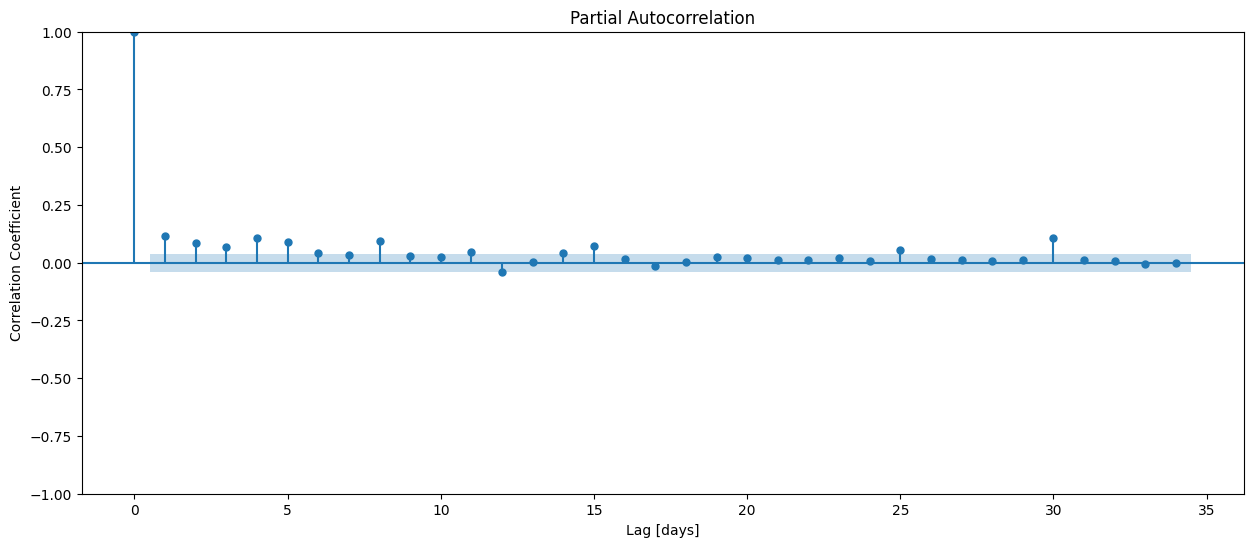

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create PACF of squared returns
plot_pacf(y_FX_USDEUR**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")

### Split data

In [ ]:
cutoff_test = int(len(y_FX_USDEUR) * 0.8)
y_usd_train = y_FX_USDEUR.iloc[:cutoff_test]

y_usd_train.head()

date
2014-11-25   -0.273768
2014-11-26   -0.262041
2014-11-27    0.362817
2014-11-28    0.074794
2014-12-01   -0.161933
Name: return, dtype: float64

# Model Building

In [ ]:
# Build and train model
model = arch_model(
  y_usd_train,
  p=1,
  q=1,
  rescale=False
).fit(disp=0)
print("model type:", type(model))

# Show model summary
model.summary()

model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1303.00
Distribution:                  Normal   AIC:                           2613.99
Method:            Maximum Likelihood   BIC:                           2636.38
                                        No. Observations:                 1990
Date:                Thu, Jun 06 2024   Df Residuals:                     1989
Time:                        18:30:43   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         7.7946e-03  9.737e-03      0.800      0.423 [-1.129e-02,2.688e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.2253e-03  8.655e-04      1.416      0.157 [-4.710e-04,2.922e-03]
alpha[1]       0.0357  9.953e-03      3.584  3.378e-04  [1.617e-02,5.518e-02]
beta[1]        0.9599  1.190e-02     80.649      0.000      [  0.937,  0.983]
=============================================================================

Covariance estimator: robust
"""

#### Bien sûr, j'ai testé plusieurs combinaisons de paramètres pour modèle et comme toujours le couple (1,1) donne de meilleurs performances.

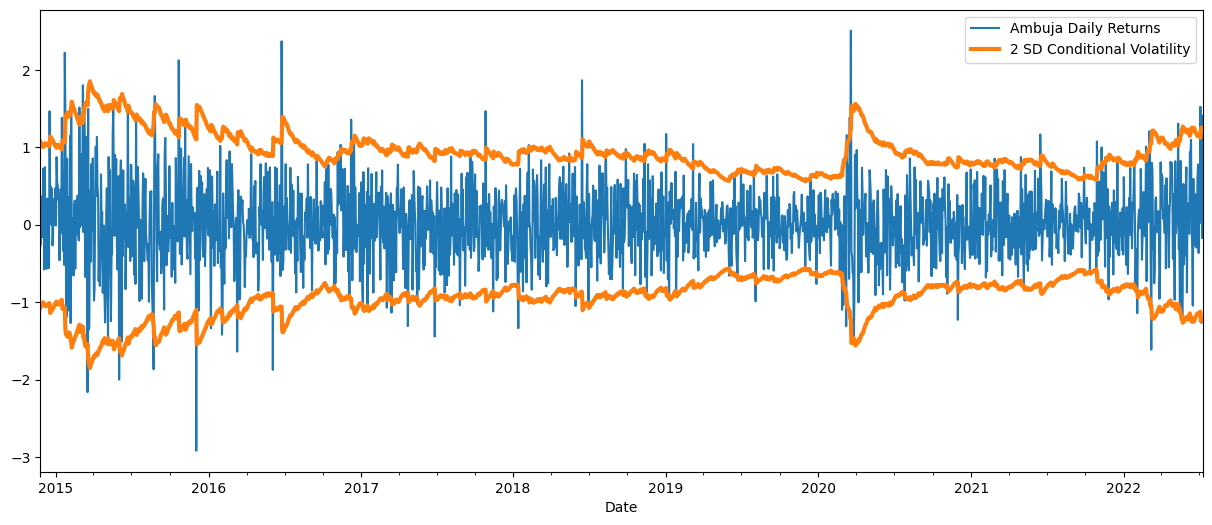

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_usd_train`
y_usd_train.plot(ax=ax,label="Ambuja Daily Returns")

# Plot conditional volatility * 2
(2 * model.conditional_volatility).plot(
    ax=ax, color="C1", label="2 SD Conditional Volatility", linewidth=3
)

# Plot conditional volatility * -2
(-2 * model.conditional_volatility.rename("")).plot(
    ax=ax, color="C1", linewidth=3
)

# Add axis labels
plt.xlabel("Date")


# Add legend
plt.legend();

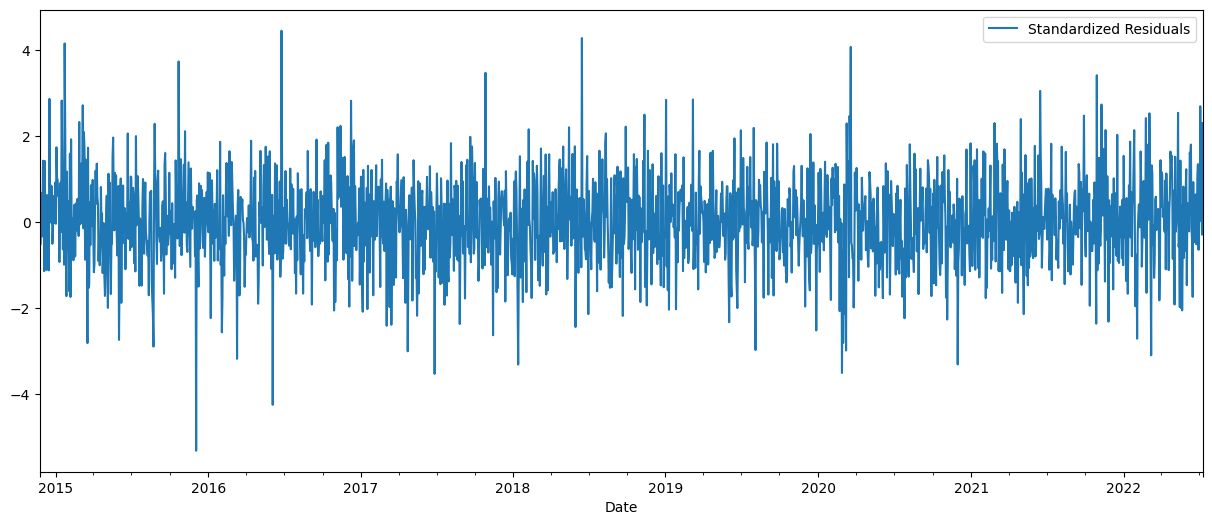

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

model.std_resid.plot(ax=ax, label="Standardized Residuals")

plt.xlabel("Date")

plt.legend();

Text(0.5, 1.0, 'Distribution od Standardized Residuals')

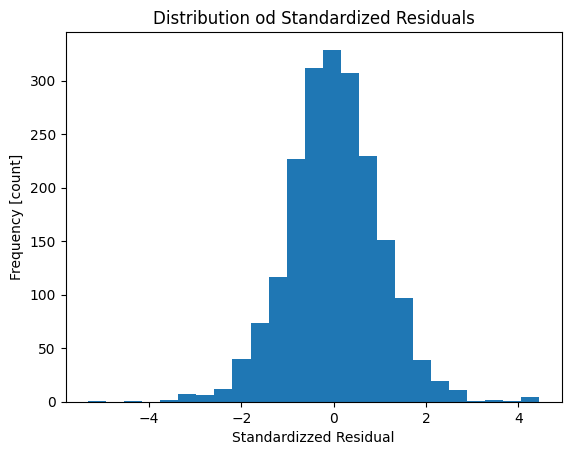

In [ ]:
plt.hist(model.std_resid, bins=25)

plt.xlabel("Standardizzed Residual")
plt.ylabel("Frequency [count]")

plt.title("Distribution od Standardized Residuals")

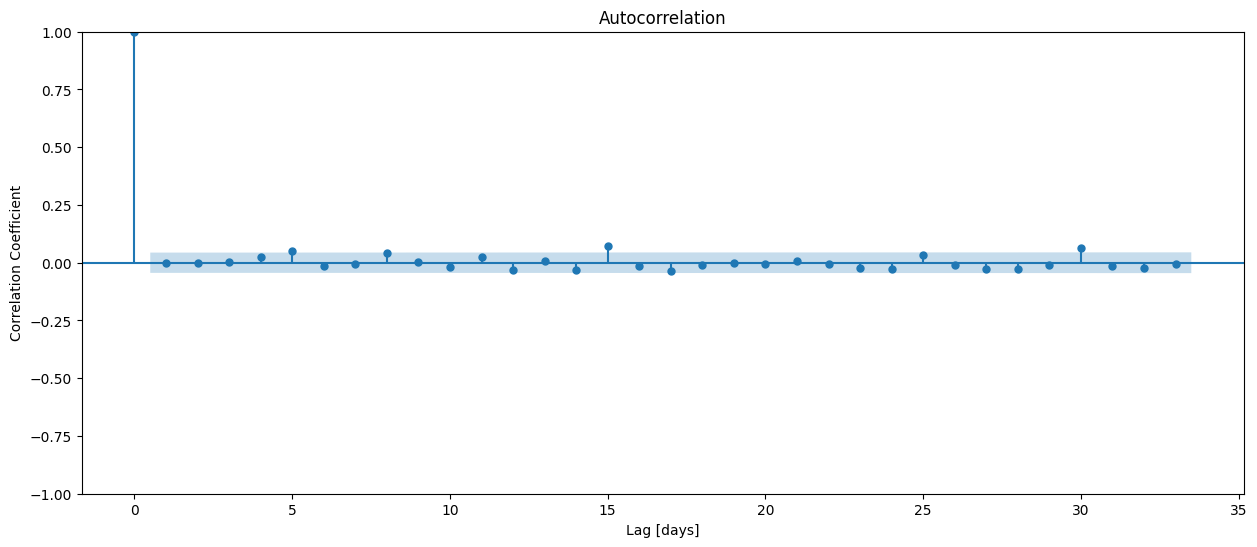

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

plot_acf(model.std_resid**2, ax=ax)

plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");


### Evaluation

In [ ]:
one_day_forecast = model.forecast(horizon=1, reindex=False).variance

print("one_day_forecast type:", type(one_day_forecast))
one_day_forecast

one_day_forecast type: <class 'pandas.core.frame.DataFrame'>


,h.1
date,
2022-07-11,0.4241


In [ ]:
predictions = []

test_size = int(len(y_FX_USDEUR) * 0.2)

for i in range(test_size):
  y_train = y_FX_USDEUR.iloc[: -(test_size - i)] # Create test data
  model = arch_model(y_train, p=1, q=1, rescale=False).fit(disp=False) # Train model
  next_pred = model.forecast(horizon=1, reindex=False).variance.iloc[0,0] ** 0.5 #Generate next prediction (volatility, not variance)
  predictions.append(next_pred) #Append prediction to list

# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=y_FX_USDEUR.tail(test_size).index)

print("y_test_wfv type:", type(y_test_wfv))
print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.head()

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (497,)


date
2022-07-13    0.638493
2022-07-14    0.627817
2022-07-15    0.619451
2022-07-18    0.619811
2022-07-19    0.619179
dtype: float64

In [ ]:
len(y_FX_USDEUR)

2488

In [ ]:
y_test = y_FX_USDEUR[-test_size:]
test_size
for i in range(test_size):
  # Create test data
  y_train = y_FX_USDEUR.iloc[: -(test_size - i)]
  #print(len(y_train))

In [ ]:
df_predictions = pd.DataFrame({"y_test": y_test, "predictions": predictions})
fig = px.line(df_predictions, labels={"value": "USD->EUR"})
fig.show()

In [ ]:
df_predictions.head()

,y_test,predictions
date,,
2022-07-13,-0.230854,0.638493
2022-07-14,0.362173,0.627817
2022-07-15,-0.631516,0.619451
2022-07-18,-0.605266,0.619811
2022-07-19,-0.801786,0.619179


### Plot returns for test data

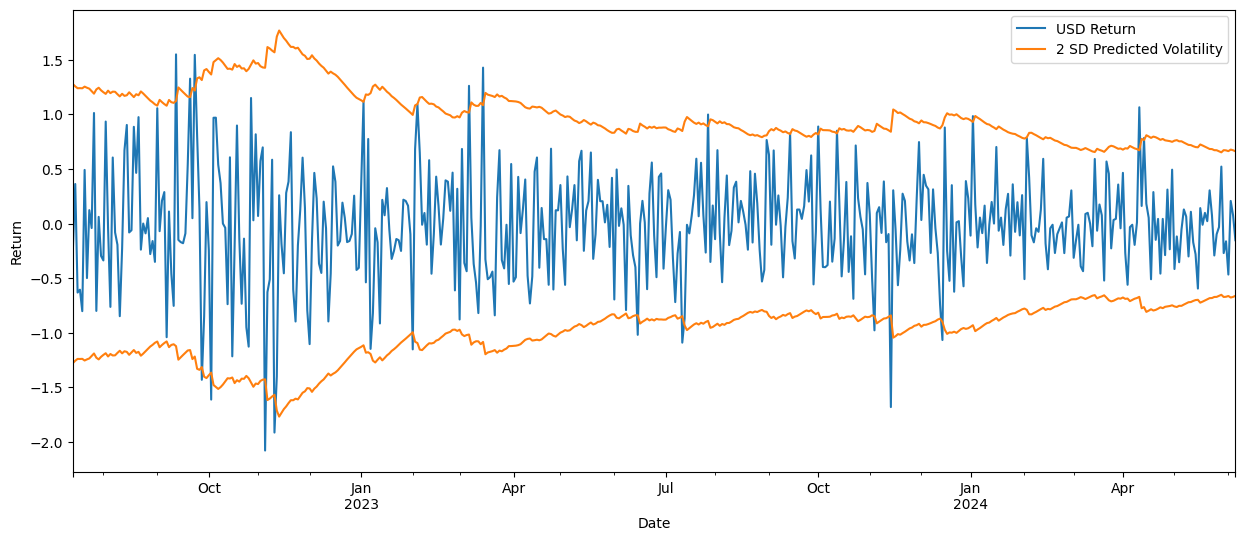

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

y_FX_USDEUR.tail(test_size).plot(ax=ax, label="USD Return")

(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

(-2 * y_test_wfv).plot(ax=ax, c="C1")

plt.xlabel("Date")
plt.ylabel("Return")

plt.legend();